In [26]:
### Load Video and Inspect Frame Counts and Resolution
import av
import os
from torchvision.io.video import read_video

video_path = os.path.join("Nov25", "korean.mp4")
video, audio, meta = read_video(video_path, pts_unit="sec",output_format="TCHW" )
print(meta)

{'video_fps': 29.87940564209317}


In [27]:
import math

fps = math.ceil(meta["video_fps"])
total_frame = len(video)
sample_rate = math.floor(total_frame/fps)
print(fps, total_frame, sample_rate, video[0])

30 98 3 tensor([[[220, 220, 220,  ..., 149, 150, 150],
         [220, 220, 221,  ..., 149, 149, 149],
         [220, 220, 221,  ..., 147, 147, 147],
         ...,
         [255, 255, 255,  ..., 154, 155, 150],
         [255, 255, 255,  ..., 149, 149, 146],
         [255, 255, 255,  ..., 146, 145, 142]],

        [[230, 230, 230,  ..., 144, 145, 145],
         [230, 230, 231,  ..., 144, 144, 144],
         [230, 230, 231,  ..., 142, 142, 142],
         ...,
         [255, 255, 255,  ..., 150, 151, 146],
         [255, 255, 255,  ..., 145, 145, 142],
         [255, 255, 255,  ..., 142, 141, 138]],

        [[238, 238, 238,  ..., 130, 131, 131],
         [238, 238, 239,  ..., 130, 130, 130],
         [238, 238, 239,  ..., 128, 128, 128],
         ...,
         [255, 255, 255,  ..., 142, 143, 138],
         [255, 255, 255,  ..., 137, 137, 134],
         [255, 255, 255,  ..., 134, 133, 130]]], dtype=torch.uint8)


1088 1920


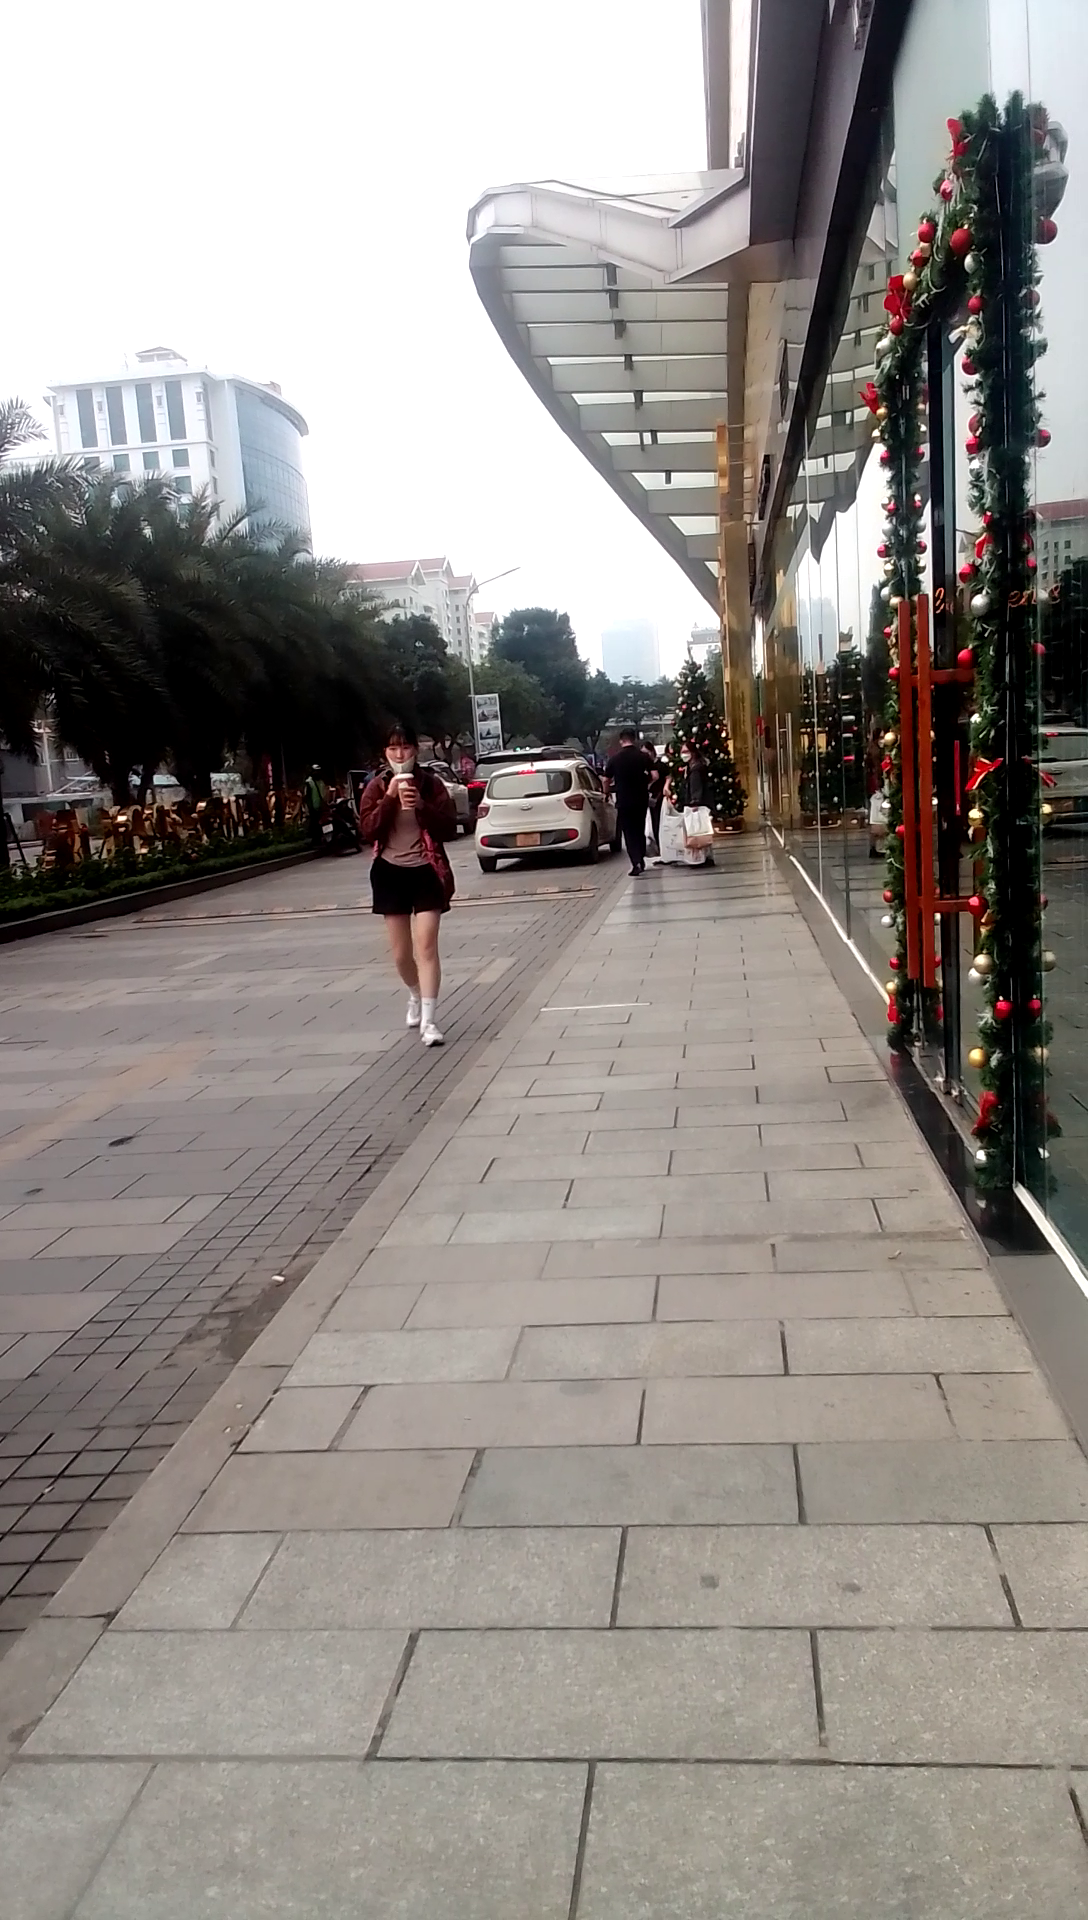

In [28]:
import torchvision.transforms.functional as F

image = F.to_pil_image(video[0])
image = image.rotate(270, expand=True)
print(image.width, image.height)
image

In [29]:
# Run Keypoint Detection on one Frame per Second and Queue Frame into Array
# https://pytorch.org/vision/main/models/generated/torchvision.models.detection.keypointrcnn_resnet50_fpn.html

import torch
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model = keypointrcnn_resnet50_fpn(weights=weights)
transforms = weights.transforms()
model.eval().to("cpu")                  

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [30]:
### Draw Boudingbox and Keypoint on each Predicted Frame
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from torchvision.utils import draw_keypoints, draw_bounding_boxes

def detect(frame):
    person_matrix = transforms(frame)
    predictions = model([person_matrix.to("cpu")])
    
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']
    boxes = predictions[0]['boxes']
    
    print("\n KEYPOINTS \n", keypoints)
    print("\n BOXES \n", boxes)
    print("\n SCORES \n", scores)
    
    top = torch.max(scores)
    idx = torch.where(scores == top)
                         
    kp = torch.unsqueeze(keypoints[idx][0], dim=0) 
    bx = torch.unsqueeze(boxes[idx][0], dim=0) 
    
    tensor_image = pil_to_tensor(frame)             
    keypoints_image = draw_keypoints(tensor_image, kp, colors="white", radius=3)
    output_image = draw_bounding_boxes(keypoints_image, bx, colors="blue", fill=True)
    
    return to_pil_image(output_image)

In [31]:
### Generate new Video from Frames
import numpy as np
import av

container = av.open("output.mp4", mode="w")

stream = container.add_stream("mpeg4", rate=fps)
stream.width = 720
stream.height = 1280
stream.pix_fmt = "yuv420p"

for idx, frame in enumerate(video):
    image = to_pil_image(frame)
    image = image.rotate(90, expand=True)
    
    def encode(image):
        frame = av.VideoFrame.from_image(image)
        for packet in stream.encode(frame):
            container.mux(packet)
            
    if idx % 6 == 0:
        image = detect(image)
        encode(image)
    else:
        encode(image)
        

# Flush stream
for packet in stream.encode():
    container.mux(packet)

# Close the file
container.close()


 KEYPOINTS 
 tensor([[[6.8219e+02, 1.1158e+03, 1.0000e+00],
         [6.9783e+02, 1.1230e+03, 1.0000e+00],
         [6.9783e+02, 1.1230e+03, 1.0000e+00],
         ...,
         [6.8361e+02, 9.5173e+02, 1.0000e+00],
         [6.5944e+02, 9.0710e+02, 1.0000e+00],
         [6.8361e+02, 1.1446e+03, 1.0000e+00]],

        [[4.0144e+02, 1.1710e+03, 1.0000e+00],
         [4.0285e+02, 1.1696e+03, 1.0000e+00],
         [4.0004e+02, 1.1681e+03, 1.0000e+00],
         ...,
         [3.9021e+02, 1.2269e+03, 1.0000e+00],
         [4.0144e+02, 1.2485e+03, 1.0000e+00],
         [3.8881e+02, 1.2499e+03, 1.0000e+00]],

        [[9.0653e+02, 1.1199e+03, 1.0000e+00],
         [8.9101e+02, 1.1100e+03, 1.0000e+00],
         [9.0512e+02, 1.1171e+03, 1.0000e+00],
         ...,
         [8.9665e+02, 1.1768e+03, 1.0000e+00],
         [9.1782e+02, 1.1512e+03, 1.0000e+00],
         [9.1499e+02, 1.1512e+03, 1.0000e+00]],

        ...,

        [[9.6653e+02, 1.1034e+03, 1.0000e+00],
         [9.6937e+02, 1.1005e+0


 KEYPOINTS 
 tensor([[[6.9948e+02, 1.0662e+03, 1.0000e+00],
         [7.4109e+02, 1.0993e+03, 1.0000e+00],
         [6.9517e+02, 1.0677e+03, 1.0000e+00],
         ...,
         [7.2243e+02, 9.1687e+02, 1.0000e+00],
         [7.0952e+02, 8.4650e+02, 1.0000e+00],
         [7.0952e+02, 8.4650e+02, 1.0000e+00]],

        [[9.6816e+02, 1.0812e+03, 1.0000e+00],
         [9.7103e+02, 1.0784e+03, 1.0000e+00],
         [9.6672e+02, 1.0784e+03, 1.0000e+00],
         ...,
         [9.7103e+02, 1.1336e+03, 1.0000e+00],
         [9.5811e+02, 1.1251e+03, 1.0000e+00],
         [9.5811e+02, 1.1251e+03, 1.0000e+00]],

        [[8.1945e+02, 1.1052e+03, 1.0000e+00],
         [8.2087e+02, 1.1024e+03, 1.0000e+00],
         [8.1803e+02, 1.1024e+03, 1.0000e+00],
         ...,
         [8.1945e+02, 1.1740e+03, 1.0000e+00],
         [8.4639e+02, 1.1597e+03, 1.0000e+00],
         [8.1945e+02, 1.1797e+03, 1.0000e+00]],

        ...,

        [[8.2071e+02, 1.1026e+03, 1.0000e+00],
         [8.2212e+02, 1.0998e+0


 KEYPOINTS 
 tensor([[[7.3930e+02, 1.0569e+03, 1.0000e+00],
         [7.7641e+02, 1.1315e+03, 1.0000e+00],
         [7.5643e+02, 1.1344e+03, 1.0000e+00],
         ...,
         [7.2074e+02, 9.0465e+02, 1.0000e+00],
         [7.4215e+02, 8.3860e+02, 1.0000e+00],
         [7.4501e+02, 8.4578e+02, 1.0000e+00]],

        [[4.6020e+02, 1.0537e+03, 1.0000e+00],
         [4.5876e+02, 1.0523e+03, 1.0000e+00],
         [4.5589e+02, 1.0508e+03, 1.0000e+00],
         ...,
         [4.5014e+02, 1.1183e+03, 1.0000e+00],
         [4.7026e+02, 1.1398e+03, 1.0000e+00],
         [4.5876e+02, 1.1498e+03, 1.0000e+00]],

        [[2.1568e+02, 1.1611e+03, 1.0000e+00],
         [2.1849e+02, 1.1568e+03, 1.0000e+00],
         [2.1287e+02, 1.1568e+03, 1.0000e+00],
         ...,
         [2.3114e+02, 1.2604e+03, 1.0000e+00],
         [2.2833e+02, 1.3021e+03, 1.0000e+00],
         [2.2973e+02, 1.3021e+03, 1.0000e+00]],

        ...,

        [[7.7230e+01, 1.3021e+03, 1.0000e+00],
         [9.4945e+01, 1.2993e+0


 KEYPOINTS 
 tensor([[[7.6443e+02, 1.0337e+03, 1.0000e+00],
         [7.9010e+02, 1.1328e+03, 1.0000e+00],
         [7.9153e+02, 1.1328e+03, 1.0000e+00],
         [7.7584e+02, 1.1227e+03, 1.0000e+00],
         [7.3020e+02, 1.0078e+03, 1.0000e+00],
         [8.2434e+02, 1.0552e+03, 1.0000e+00],
         [8.2148e+02, 1.0581e+03, 1.0000e+00],
         [7.9724e+02, 8.7419e+02, 1.0000e+00],
         [8.3860e+02, 1.0940e+03, 1.0000e+00],
         [7.9296e+02, 1.1299e+03, 1.0000e+00],
         [7.3163e+02, 8.3252e+02, 1.0000e+00],
         [7.6443e+02, 9.6613e+02, 1.0000e+00],
         [7.6443e+02, 9.7044e+02, 1.0000e+00],
         [7.9153e+02, 8.7419e+02, 1.0000e+00],
         [7.4589e+02, 8.7275e+02, 1.0000e+00],
         [7.8155e+02, 7.8368e+02, 1.0000e+00],
         [7.8155e+02, 7.8368e+02, 1.0000e+00]],

        [[5.0122e+02, 1.0562e+03, 1.0000e+00],
         [5.0262e+02, 1.0533e+03, 1.0000e+00],
         [4.9841e+02, 1.0533e+03, 1.0000e+00],
         [5.0262e+02, 1.0519e+03, 1.0000e+00


 KEYPOINTS 
 tensor([[[8.1826e+02, 1.1630e+03, 1.0000e+00],
         [7.9674e+02, 1.1472e+03, 1.0000e+00],
         [7.9817e+02, 1.1472e+03, 1.0000e+00],
         [7.8382e+02, 1.1300e+03, 1.0000e+00],
         [7.8526e+02, 1.1257e+03, 1.0000e+00],
         [8.4983e+02, 1.0567e+03, 1.0000e+00],
         [7.3933e+02, 9.7334e+02, 1.0000e+00],
         [8.5414e+02, 1.0998e+03, 1.0000e+00],
         [7.9387e+02, 1.1027e+03, 1.0000e+00],
         [8.0104e+02, 1.1458e+03, 1.0000e+00],
         [7.9961e+02, 1.1429e+03, 1.0000e+00],
         [7.7808e+02, 9.7190e+02, 1.0000e+00],
         [7.6516e+02, 9.6328e+02, 1.0000e+00],
         [7.9961e+02, 8.8425e+02, 1.0000e+00],
         [7.6660e+02, 8.8712e+02, 1.0000e+00],
         [7.6516e+02, 7.9372e+02, 1.0000e+00],
         [7.6516e+02, 7.9372e+02, 1.0000e+00]],

        [[4.8580e+02, 1.0477e+03, 1.0000e+00],
         [4.7723e+02, 1.0462e+03, 1.0000e+00],
         [4.7723e+02, 1.0448e+03, 1.0000e+00],
         [4.8580e+02, 1.0448e+03, 1.0000e+00


 KEYPOINTS 
 tensor([[[7.9844e+02, 1.1009e+03, 1.0000e+00],
         [8.0559e+02, 1.1426e+03, 1.0000e+00],
         [8.0702e+02, 1.1426e+03, 1.0000e+00],
         ...,
         [8.0416e+02, 8.6334e+02, 1.0000e+00],
         [7.7983e+02, 7.5824e+02, 1.0000e+00],
         [7.7983e+02, 7.6112e+02, 1.0000e+00]],

        [[5.2552e+02, 1.0371e+03, 1.0000e+00],
         [5.2835e+02, 1.0328e+03, 1.0000e+00],
         [5.2410e+02, 1.0328e+03, 1.0000e+00],
         ...,
         [5.0997e+02, 1.1118e+03, 1.0000e+00],
         [5.2410e+02, 1.1362e+03, 1.0000e+00],
         [5.1562e+02, 1.1376e+03, 1.0000e+00]],

        [[4.5106e+02, 1.0490e+03, 1.0000e+00],
         [4.5106e+02, 1.0461e+03, 1.0000e+00],
         [4.5106e+02, 1.0476e+03, 1.0000e+00],
         ...,
         [4.8070e+02, 1.1239e+03, 1.0000e+00],
         [4.9482e+02, 1.1383e+03, 1.0000e+00],
         [4.9482e+02, 1.1369e+03, 1.0000e+00]],

        ...,

        [[2.0595e+02, 1.1370e+03, 1.0000e+00],
         [2.0731e+02, 1.1356e+0

TypeError: 'NoneType' object is not iterable

Exception ignored in: 'av.container.output.OutputContainer.__dealloc__'
Traceback (most recent call last):
  File "av/container/output.pyx", line 25, in av.container.output.close_output
TypeError: 'NoneType' object is not iterable


tensor([[ 733.0894,  685.1906,  905.1417, 1201.9294],
        [ 499.5821, 1035.0254,  547.9311, 1149.3121],
        [ 513.5045, 1063.1327,  545.8734, 1151.0597],
        [ 948.6680, 1060.0261,  973.3715, 1141.1316],
        [ 528.7725, 1024.6895,  589.1335, 1145.2968],
        [ 520.5294, 1062.4977,  573.7896, 1153.6969],
        [ 967.9114, 1081.5386,  990.5677, 1145.5236],
        [ 493.7581, 1091.8535,  519.5870, 1149.9838],
        [ 515.9031, 1103.5725,  545.8682, 1153.2455],
        [ 457.7988, 1047.1423,  507.6751, 1161.1478],
        [  66.0830, 1301.8265,   91.9484, 1394.6215],
        [ 542.7878, 1043.5400,  607.1552, 1150.7521],
        [1037.3796, 1068.3423, 1077.2869, 1110.8771],
        [ 940.1077, 1061.5337,  982.4565, 1154.3990],
        [ 482.1674, 1045.3595,  527.2229, 1153.9717],
        [ 541.0280, 1072.5670,  579.9835, 1153.0802],
        [1055.4429, 1048.4537, 1085.2180, 1104.9521],
        [ 487.6371, 1082.9359,  539.5192, 1158.2450],
        [  40.8677, 1304.444


 KEYPOINTS 
 tensor([[[8.3851e+02, 1.0515e+03, 1.0000e+00],
         [8.7283e+02, 1.1566e+03, 1.0000e+00],
         [8.3708e+02, 1.0674e+03, 1.0000e+00],
         ...,
         [8.1133e+02, 7.7518e+02, 1.0000e+00],
         [8.4709e+02, 6.7012e+02, 1.0000e+00],
         [8.4566e+02, 6.7012e+02, 1.0000e+00]],

        [[5.7561e+02, 1.0331e+03, 1.0000e+00],
         [5.7703e+02, 1.0302e+03, 1.0000e+00],
         [5.7278e+02, 1.0316e+03, 1.0000e+00],
         ...,
         [5.6995e+02, 1.0791e+03, 1.0000e+00],
         [5.8410e+02, 1.1079e+03, 1.0000e+00],
         [5.7420e+02, 1.1021e+03, 1.0000e+00]],

        [[2.3506e+02, 1.1358e+03, 1.0000e+00],
         [2.1689e+02, 1.1415e+03, 1.0000e+00],
         [2.1270e+02, 1.1430e+03, 1.0000e+00],
         ...,
         [2.3086e+02, 1.2406e+03, 1.0000e+00],
         [2.2807e+02, 1.2865e+03, 1.0000e+00],
         [2.2947e+02, 1.2850e+03, 1.0000e+00]],

        ...,

        [[1.3387e+02, 1.0794e+03, 1.0000e+00],
         [1.3674e+02, 1.0766e+0